In [ ]:
#This notebook performs binary classification of the KDD-99 NSL data Using . Goal is to separate "normal" traffic from abnormal. 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix


def get_local_dataset(PATH, header=None):
    try:
        df = pd.read_csv(PATH,header=header)
    except:
        print('Error loading local dataset.')
        raise
    df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
    print('Read {} rows.'.format(len(df)))
    return df

def set_KDD_columns(kdd_df):
    kdd_df.columns = [
        'duration',
        'protocol_type',
        'service',
        'flag',
        'src_bytes',
        'dst_bytes',
        'land',
        'wrong_fragment',
        'urgent',
        'hot',
        'num_failed_logins',
        'logged_in',
        'num_compromised',
        'root_shell',
        'su_attempted',
        'num_root',
        'num_file_creations',
        'num_shells',
        'num_access_files',
        'num_outbound_cmds',
        'is_host_login',
        'is_guest_login',
        'count',
        'srv_count',
        'serror_rate',
        'srv_serror_rate',
        'rerror_rate',
        'srv_rerror_rate',
        'same_srv_rate',
        'diff_srv_rate',
        'srv_diff_host_rate',
        'dst_host_count',
        'dst_host_srv_count',
        'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate',
        'dst_host_srv_serror_rate',
        'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate',
        'outcome',
        'difficulty_rating'
    ]
    #return kdd_df

def encode_zscore(df, name, mean=None, std_dev=None):
    '''Encode numeric values as zscore'''
    if mean == None:
        mean = df[name].mean()
    if std_dev == None:
        std_dev = df[name].std()
    df[name] = (df[name] - mean) / std_dev

def encode_text(df, name):
    '''Encode text values to binary dummy values (i.e. red,blue is [0,1] or [1,0])'''
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        new_name = f"{name}-{x}"
        df[new_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def reencode_dataset(df):
    '''Takes a KDD pandas dataframe and transforms the data by 
    changing numeric columns to zscore, and text columns to 
    dummy values'''

    encode_zscore(df, 'duration')
    encode_text(df, 'protocol_type')
    encode_text(df, 'service')
    encode_text(df, 'flag')
    encode_zscore(df, 'src_bytes')
    encode_zscore(df, 'dst_bytes')
    encode_text(df, 'land')
    encode_zscore(df, 'wrong_fragment')
    encode_zscore(df, 'urgent')
    encode_zscore(df, 'hot')
    encode_zscore(df, 'num_failed_logins')
    encode_text(df, 'logged_in')
    encode_zscore(df, 'num_compromised')
    encode_zscore(df, 'root_shell')
    encode_zscore(df, 'su_attempted')
    encode_zscore(df, 'num_root')
    encode_zscore(df, 'num_file_creations')
    encode_zscore(df, 'num_shells')
    encode_zscore(df, 'num_access_files')
    encode_zscore(df, 'num_outbound_cmds')
    encode_text(df, 'is_host_login')
    encode_text(df, 'is_guest_login')
    encode_zscore(df, 'count')
    encode_zscore(df, 'srv_count')
    encode_zscore(df, 'serror_rate')
    encode_zscore(df, 'srv_serror_rate')
    encode_zscore(df, 'rerror_rate')
    encode_zscore(df, 'srv_rerror_rate')
    encode_zscore(df, 'same_srv_rate')
    encode_zscore(df, 'diff_srv_rate')
    encode_zscore(df, 'srv_diff_host_rate')
    encode_zscore(df, 'dst_host_count')
    encode_zscore(df, 'dst_host_srv_count')
    encode_zscore(df, 'dst_host_same_srv_rate')
    encode_zscore(df, 'dst_host_diff_srv_rate')
    encode_zscore(df, 'dst_host_same_src_port_rate')
    encode_zscore(df, 'dst_host_srv_diff_host_rate')
    encode_zscore(df, 'dst_host_serror_rate')
    encode_zscore(df, 'dst_host_srv_serror_rate')
    encode_zscore(df, 'dst_host_rerror_rate')
    encode_zscore(df, 'dst_host_srv_rerror_rate')

    #return df

def generate_training_set(df, num_outcomes,frac=0.1):
    '''This doesn't work well right now. FIX ME!!!'''
    while True:
        df_train = df.sample(frac=frac, replace=False)
        dummies = pd.get_dummies(df_train['outcome'])
        if len(dummies.columns) != num_outcomes:
            continue
        x_columns = df_train.columns.drop(['outcome','difficulty_rating'])
        x = df_train[x_columns].values
        y = dummies.values
        break

    print(df_train.groupby('outcome')['outcome'].count())
    print(df_train.head())
    print(df_train.columns)

    return x, y



In [2]:
from sklearn.cluster import KMeans

df = get_local_dataset('./nslkdd/KDDTest+.txt')
print(len(df))
set_KDD_columns(df)
reencode_dataset(df)

df.dropna(inplace=True, axis=1)

x, y = generate_training_set(df,df['outcome'].nunique(), frac=1.0)



Read 22544 rows.
22544
outcome
apache2             737
back                359
buffer_overflow      20
ftp_write             3
guess_passwd       1231
httptunnel          133
imap                  1
ipsweep             141
land                  7
loadmodule            2
mailbomb            293
mscan               996
multihop             18
named                17
neptune            4657
nmap                 73
normal             9711
perl                  2
phf                   2
pod                  41
portsweep           157
processtable        685
ps                   15
rootkit              13
saint               319
satan               735
sendmail             14
smurf               665
snmpgetattack       178
snmpguess           331
sqlattack             2
teardrop             12
udpstorm              2
warezmaster         944
worm                  2
xlock                 9
xsnoop                4
xterm                13
Name: outcome, dtype: int64
       duration  src_bytes  d

In [3]:
df.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_host_login-1,is_guest_login-0,is_guest_login-1
count,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,2.269299e-17,3.151804e-19,6.146018e-18,1.765010e-17,-6.303608e-19,-5.673248e-18,-4.097345e-18,-3.151804e-19,2.316576e-17,-5.673248e-18,...,0.659821,0.003238,0.999689,0.000311,0.557798,0.442202,0.999512,0.000488,0.971567,0.028433
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.473780,0.056813,0.017619,0.017619,0.496659,0.496659,0.022084,0.022084,0.166211,0.166211
min,-1.555306e-01,-2.198762e-02,-9.689382e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.555306e-01,-2.198762e-02,-9.689382e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,-1.555306e-01,-2.187341e-02,-9.472598e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,-1.555306e-01,-2.138058e-02,-6.857055e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,4.085922e+01,1.328618e+02,6.333249e+01,2.097894e+01,8.223296e+01,1.086725e+02,2.646453e+01,1.094806e+02,2.022060e+01,9.495388e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
from sklearn.preprocessing import StandardScaler

df['outcome'].head()
x_df = df.drop(['outcome'], axis=1)
x_df = StandardScaler().fit_transform(x_df)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



In [6]:
# len(principalDf)
# principalDf[:3]

In [7]:
# import seaborn as sns
# g = sns.pairplot(principalDf)

In [8]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2)
km.fit(principalDf)
y_kmeans = km.predict(principalDf)

In [9]:
#this block prepares a true_normal_df for visualization, so we can compare against the two groups generated by K-Means Clustering
true_normal_df = principalDf.copy() #get the PCA1 and PCA2 columns from the principalDf (original df), copy them into a new true_normal_df
true_normal_df['outcome'] = df['outcome'] #copy the outcome column from the original dataframe to the true_normal_df
true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 'normal'].index) #delete all rows from the true_normal_df that have an outcome that is NOT normal
print(len(true_normal_df['outcome']), (true_normal_df.outcome == 'normal').sum()) #proof that every outcome in our table is normal
true_normal_df.drop(['outcome'], axis = 1) #finally, drop the outcome column from the true_normal_df, and we are left with PCA1 and PCA2 cols that correspond to the true normal rows, so we can plot and visualize these in the next step

9711 9711


,principal component 1,principal component 2
2,-1.059091,0.185688
5,-2.885731,-0.380176
6,-0.523860,-0.912861
8,-2.855235,-0.389038
11,-1.738291,-0.684446
...,...,...
22533,-2.973286,-0.409606
22535,-3.126928,-0.420642
22539,-2.243841,-0.350808
22540,-2.817083,-0.400750


In [10]:
import matplotlib.pyplot as plt

scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")
# Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data
plt.show()

<Figure size 640x480 with 1 Axes>

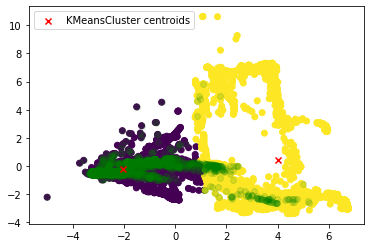

In [11]:
import matplotlib.pyplot as plt

scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(true_normal_df['principal component 1'], true_normal_df['principal component 2'], color = 'g', alpha = 0.15)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")
# Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data
# We can confirm that the left is normal data by overlaying it with the values found in true_normal_df
plt.show()

In [14]:
#Check accuracy of the Kmeans clustering predicted values. To do this:

#check alignment between the y_kmeans (which are the Kmeans predicted values) and one of the two clusters. 

#there are two possible ways that Kmeans_predicted_values could have been encoded. 1's may represent normal, or 1's may represent abnormal
#Below, we will check both possibilites, and return the case which matches our true binary_encoded_outcome.
binary_encoded_outcome = df['outcome'].apply(lambda x: 1 if x == 'normal' else 0 )

#comparison_df will be used to compare the two possible binary encodings of "normal" from y_kmeans with the true outcome encoded in binary (called Binary_encoded_outcome)
comparison_df = pd.DataFrame()
comparison_df['Binary_encoded_outcome'] = binary_encoded_outcome
comparison_df['Kmeans_predicted_A'] = y_kmeans

comparison_df['Kmeans_predicted_B'] = comparison_df['Kmeans_predicted_A'].apply(lambda x: 0 if x == 1 else 1 ) #flip 0s and 1's

total_true_values = len(df['outcome'])

if (comparison_df['Binary_encoded_outcome'] == comparison_df['Kmeans_predicted_A']).sum() > (comparison_df['Binary_encoded_outcome'] == comparison_df['Kmeans_predicted_B']).sum():
    principalDf['Kmeans_predicted'] = comparison_df['Kmeans_predicted_A']
else:
    principalDf['Kmeans_predicted'] = comparison_df['Kmeans_predicted_B']

principalDf['true_outcome'] = binary_encoded_outcome

correctly_predicted = (principalDf['Kmeans_predicted'] == principalDf['true_outcome']).sum()
print('Kmeans correctly predicted', correctly_predicted, 'out of', total_true_values, 'Accuracy: ', round(correctly_predicted/total_true_values, 3) * 100, '%')


Kmeans correctly predicted 16926 out of 22544 Accuracy:  75.1 %
